In [1]:
import pandas as pd
import numpy as np

## Exploration des données

In [2]:
df = pd.read_csv("strokes.csv", index_col="id")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
print("- Nombre d'observations et de variables : ", df.shape,'\n')
print("- Variables explicatives/expliquée et type : ")
df.info()

- Nombre d'observations et de variables :  (5110, 11) 

- Variables explicatives/expliquée et type : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [4]:
#Vérification des valeurs uniques de chaque colonne :
for i in df:
    print(df[i].unique())

['Male' 'Female' 'Other']
[6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01 4.00e-01 8.00e-02 1.48e+00 5.60e-01 4.80e-01 1.60e-01]
[0 1]
[1 0]
['Yes' 'No']

In [5]:
# Variable Age

print("- Statistiques sur la variable 'age' :\n", df['age'].describe(),'\n')
# L'écart type, les quantiles et la moyenne nous montre qu'il y a une répartition des âges homogène entre 0 et 82 ans.

df.sort_values(by = 'age', ascending = True).head(500)
print("Ages entre 0 et 2 ans :\n", df[(df.age%1 != 0.00) & (df.age<2)][['age', 'stroke']])
# Entre 0 et 2 ans, les âges sont exprimés avec des nombres décimaux, voir par la suite si c'est à corriger ou pas
# pour l'implémentation des algorithmes de ML. 

# Classes d'âge
df['age_classes'] = pd.qcut(df['age'], labels=[0, 1, 2, 3], q=4)

# répartition des attaques selon la classe d'âge
df_ca = df.groupby(['age_classes', 'stroke']).agg({'stroke' : 'count'})
df_ca.head(10)
# il y a beaucoup plus de cas de crise cardiaque chez les personnes plus âgées, c'est logique.

- Statistiques sur la variable 'age' :
 count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64 

Ages entre 0 et 2 ans :
         age  stroke
id                 
69768  1.32       1
7559   0.64       0
22706  0.88       0
45238  1.80       0
61511  0.32       0
...     ...     ...
32147  1.32       0
67426  1.24       0
42709  1.72       0
56714  0.72       0
68598  1.08       0

[115 rows x 2 columns]


stroke
age_classes stroke        
0           0         1291
            1            2
1           0         1314
            1           11
2           0         1199
            1           65
3           0         1057
            1          171

In [6]:
print("Gender :\n", df['gender'].value_counts(normalize=True),'\n')
# Proportion de femmes légèrement plus importante
print("hypertension :\n", df['hypertension'].value_counts(normalize=True),'\n')
#Très peu de cas d'hypertension
print("work_type :\n", df['work_type'].value_counts(normalize=True),'\n')
# une majorité de jobs privés
print("stroke :\n", df['stroke'].value_counts(normalize=True),'\n')
# Très faible proportion d'observations avec la variable cible 'stroke' positive donc peu de cas de crise cardiaque,attention au
# déséquilibre des classes pour la variable cible.

Gender :
 Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64 

hypertension :
 0    0.902544
1    0.097456
Name: hypertension, dtype: float64 

work_type :
 Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64 

stroke :
 0    0.951272
1    0.048728
Name: stroke, dtype: float64 



In [7]:
#Stroke analyse

print(df['stroke'].isna().sum())
print("stroke :\n", df['stroke'].value_counts(normalize=True),'\n')
#aucune valeur vide

df['stroke'].value_counts()
#249 crise cardiaque décelé
#4861 sans crise cardiaque


0
stroke :
 0    0.951272
1    0.048728
Name: stroke, dtype: float64 



0    4861
1     249
Name: stroke, dtype: int64

In [8]:
#Type de résidence
print(df['Residence_type'].isna().sum())
print("Residence_type :\n", df['Residence_type'].value_counts(normalize=True),'\n')
#aucune valeur vide

df['Residence_type'].value_counts()

print (df['Residence_type'].value_counts())

#Urban    2596
#Rural    2514

0
Residence_type :
 Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64 

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


In [9]:
#Taux de glucose
print(df['avg_glucose_level'].isna().sum())
#aucune valeur vide

df['avg_glucose_level'].describe()

#taux moyen de glucose 106.147677

0


count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

## Nettoyage des données

In [10]:

Il n'y a pas de doublons au niveau de l'index : pas besoin de supprimer de doublons
df.index.duplicated().sum()

SyntaxError: invalid syntax (Temp/ipykernel_21552/3446608766.py, line 1)

In [ ]:
print("Il y a des valeurs NaN dans la colonne bmi que l'on va remplacer par un mean")
df.isna().sum()

In [ ]:
#On remplace les valeurs NA par le mean de la colonne bmi
df_new = df.copy()

df_new.loc[:, ("bmi")] = df["bmi"].fillna(df["bmi"].mean())

#On remplace également les valeurs Unknown par le mode de la colonne
df_new = df_new.replace("Unknown", np.NaN)
df_new["smoking_status"] = df_new["smoking_status"].fillna(df_new["smoking_status"].mode()[0])
df_new.head()

In [ ]:
df_new["bmi"].describe()

## Analyse des données

In [ ]:
#Est-ce que le fait d'être marié peut avoir un impact sur la crise cardiaque ?
pd.crosstab(df_new["ever_married"], df_new["stroke"])

In [ ]:
#La même répartition en %
round(pd.crosstab(df_new["ever_married"], df_new["stroke"], normalize="index")*100,2)

In [ ]:
#Est-ce que le fait d'être fumeur peut avoir un impact sur la crise cardiaque ?
round(pd.crosstab(df_new["smoking_status"], df_new["stroke"],normalize="index")*100, 2)

#On constate un écart non significatif entre les fumeurs et les non fumeurs sur le risque de crise cardiaque.

In [ ]:
#Est-ce que le bmi peut avoir un impact sur la crise cardiaque ?

df_new["bmi_classes"] = pd.qcut(df_new["bmi"], labels=[0,1,2,3], q=4)
round(pd.crosstab(df_new["bmi_classes"], df_new["stroke"],normalize="index")*100, 2)

In [ ]:
df_new["bmi"]

In [ ]:
#Est-ce que le type de travail peut avoir un impact sur la crise cardiaque ?
round(pd.crosstab(df_new["work_type"], df_new["stroke"],normalize="index")*100, 2)
# Les cas de crise cardiaque les plus fréquents se trouvent chez les salariés du privé.
# Aucun cas chez ceux qui n'ont jamais travaillé.

In [ ]:
#Est-ce que le genre peut avoir un impact sur la crise cardiaque ?
round(pd.crosstab(df_new["gender"], df_new["stroke"],normalize="index")*100, 2)
# Un peu plus de crise cardiaque chez les hommes, tout en sachant qu'il y a un nombre plus important d'observation
# chez les femmes (58,5 %).

In [ ]:
 # Est-ce que le type de résidence est un vecteur marquant sur la crise cardiaque ?
colonne1 = df['Residence_type']
colonne2 = df['stroke']


print("Un petit peu plus de crise cardiaque en ville 135 contre 114 en campagne")

pd.crosstab(colonne1, colonne2)




In [ ]:
#Taux de glucose en fonction de l'habitation

# Quantité maximale
max_avg_glucose_level = lambda avg_glucose_level: avg_glucose_level[avg_glucose_level > 0].max()

# Quantité minimale
min_avg_glucose_level = lambda avg_glucose_level: avg_glucose_level[avg_glucose_level > 0].min()

# Quantité médiane
median_avg_glucose_level = lambda avg_glucose_level : avg_glucose_level[avg_glucose_level > 0].median()




# Définition du dictionnaire de fonctions à appliquer
functions_to_apply = {
    'avg_glucose_level' : [max_avg_glucose_level, min_avg_glucose_level, median_avg_glucose_level]
}


# Operation groupby
avg_glucose_level_groupby = df.groupby('Residence_type').agg(functions_to_apply)

# Je renomme les colonnes produite par le groupby
avg_glucose_level_groupby.columns.set_levels(['max_avg_glucose_level', 'min_avg_glucose_level', 'median_avg_glucose_level'], level=1, inplace = True)

print("les taux de glucose sont presque équivalent en ville et en campagne")

# Affichage des premières lignes du Dataframe produit par l'opération groupby
avg_glucose_level_groupby.head()



In [ ]:
print("Hypoglycémie : Inférieur à 70g/dL de sang")
print("Le taux normal de la glycémie à jeun oscille entre 70 mg/dL et 100 g/dL")
print("Hyperglycémie modérée : Entre 1 et 1.25g/L")
print("Au dessus de 126mg à jeune la personne est considéré comme diablétique")
print("Les données sont donc divisées en 4 quantile 0:70  < 70:100 < 100:125 < 125:")



df['avg_glucose_level_classes'] = pd.cut(df['avg_glucose_level'], bins=[0,70,100,125,np.inf],labels=['Hypoglycémie','Taux normal','Hyperglycémie modérée','Diablétique'])


df['avg_glucose_level_classes']


In [ ]:
state_summary=df.groupby(['avg_glucose_level_classes','gender']).agg( {"gender": 'count'})
state_summary

#nb_gender=df.groupby(['gender']).agg( {"gender": 'count'})
#nb_gender
#Etude des crises cardiaques qui dépend de sa tranche de son taux de glucose

In [ ]:
state_summary=df.groupby(['avg_glucose_level_classes','Residence_type']).agg( {"stroke": 'sum'})
state_summary
 

In [ ]:

print("Moins de crise cardiaque sur les cas en Hypoglycemie et sur ceux en Hyperglycémie modérée")
class_summary=df.groupby(['avg_glucose_level_classes']).agg({'stroke': 'sum'})


class_summary




In [ ]:
# Analyse de la variable avg_glucose_level

#Séparation de la variable
avg_glucose_level_studies=df[["avg_glucose_level"]]

#Calcul de la moyenne de la variable
stats=pd.DataFrame(avg_glucose_level_studies.mean(), columns=['moyenne'])
stats.round(2)

#Calcul de la median de la variable
stats['median']=avg_glucose_level_studies.median()

#Calcul de la différence entre la moyenne et la median de la variable
stats['mean_med_diff'] = abs(stats['moyenne'] - stats['median'])
stats.round(2)

#Calcul du quantile de la variable
quantile=avg_glucose_level_studies["avg_glucose_level"].quantile(q = [0.25,0.5,0.75])
quantile

stats[['q1', 'q2', 'q3']] = avg_glucose_level_studies.quantile(q=[0.25, 0.5, 0.75]).transpose()

#Calcul du max et minimum et de la différence de la variable
stats['min'] = avg_glucose_level_studies.min()
stats['max'] = avg_glucose_level_studies.max()
stats['min_max_diff'] = stats['max'] - stats['min']

stats

## Liaisons entre les variables

In [ ]:
df.head()



#### Analyse des liaisons entre les variables continues

Les trois variables sont indépendante p-value >5%


,age,avg_glucose_level,bmi
age,1.000000,0.238171,0.333398
avg_glucose_level,0.238171,1.000000,0.175502
bmi,0.333398,0.175502,1.000000


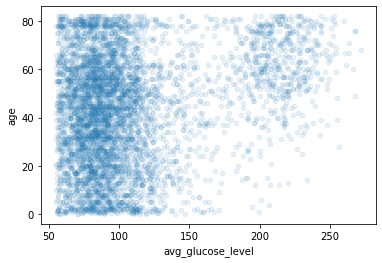

In [19]:
print("Les trois variables sont indépendante p-value >5%")


dfnum=df[['age','avg_glucose_level','bmi']]
dfnum.corr()

from pandas.plotting import scatter_matrix
%matplotlib inline

df[df['age']<100].plot(kind='scatter', x='avg_glucose_level', y='age', alpha=0.1);
dfnum.corr()

#### Analyse des liaisons entre les variables catégorielles

In [18]:
dfcat=df[['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']]


table = pd.crosstab(dfcat['work_type'],dfcat['smoking_status'])

from scipy.stats import chi2_contingency

resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]
la_liste = resultats_test[3]
print(statistique, p_valeur,degre_liberte)

table


# p-value < 5% donc on rejette H0

1389.1065677376766 3.1032817784869454e-290 12


smoking_status,Unknown,formerly smoked,never smoked,smokes
work_type,,,,
Govt_job,122,133,282,120
Never_worked,8,0,14,0
Private,640,531,1211,543
Self-employed,156,208,331,124
children,618,13,54,2


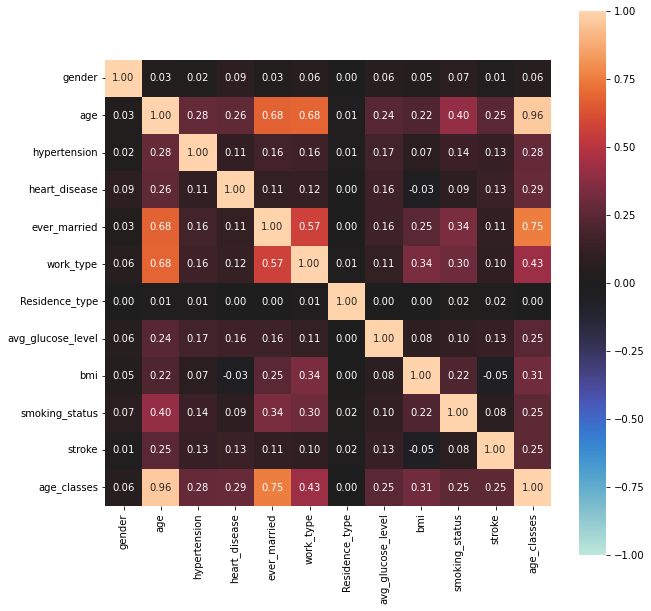

C:\Users\PYTU10~1\AppData\Local\Temp/ipykernel_21552/2274680046.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


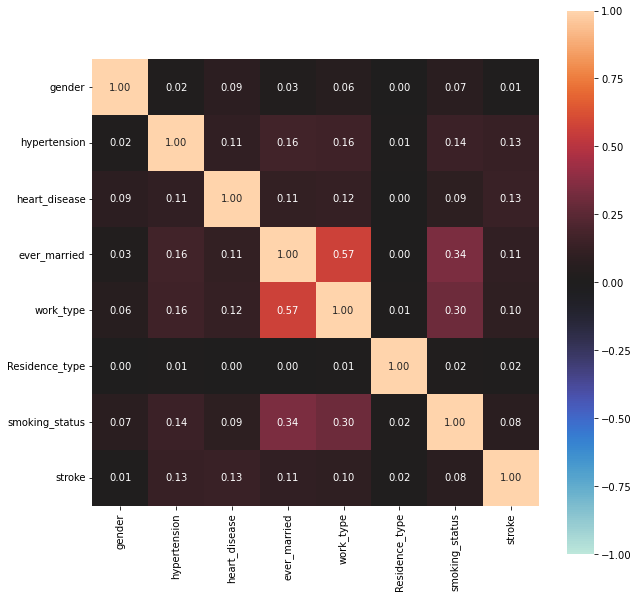

In [20]:
#https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26
# pip install dython redémarrer jupyter après
import pandas as pd
from dython.nominal import associations

from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(df)
categorical_features
['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']



complete_correlation= associations(df, filename= 'complete_correlation.png', figsize=(10,10))


df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)



categorical_correlation= associations(dfcat, filename= 'categorical_correlation.png', figsize=(10,10))

## Festivale de graphique